<div align="left">
<img align="left" src="datasciencebowl.png" >
<div> <b> Kaggle </b></div>
<div> 2018 Data Science Bowl </div>
<div> Pedro D. Marrero Fernandez</div>
<div> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47770 </div>
<div> :), :(, :/</div>
</div>            

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import csv

from deep.datasets import imageutl as utl

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [36]:
pathdataset = '../db'
namedataset = 'databoewl'
metadata = 'stage1_train_labels.csv'
pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

print(pathname)
print(pathmetadata)



../db/databoewl
../db/databoewl/stage1_train_labels.csv


In [37]:
mdata = pd.read_csv(pathmetadata)
mdata['EncodedPixels'] = mdata['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
print('Total:', len(mdata))
mdata.head()

Total: 29461


,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[6908, 1, 7161, 8, 7417, 8, 7672, 9, 7928, 9, ..."
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[36269, 7, 36523, 11, 36778, 13, 37033, 15, 37..."
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[19919, 6, 20174, 8, 20429, 10, 20685, 11, 209..."
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[18671, 6, 18926, 8, 19181, 9, 19436, 10, 1969..."
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[40158, 3, 40413, 5, 40669, 5, 40925, 5, 41182..."


In [39]:
files = np.array(mdata['ImageId'])
files = np.unique(files)
print(len(files))

670


In [2]:

pathdataset = '../db'
namedataset = 'databoewl'
metadata = 'stage1_train_labels.csv'
pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

base_folder = pathname
sub_folder =  utl.train
id_file_name = metadata
folders_image='images'
folders_masks='masks'

dataloader = utl.dsxbProvide.create(
    base_folder, 
    sub_folder, 
    id_file_name, 
    folders_image, 
    folders_masks
    )

print(len(dataloader))



670


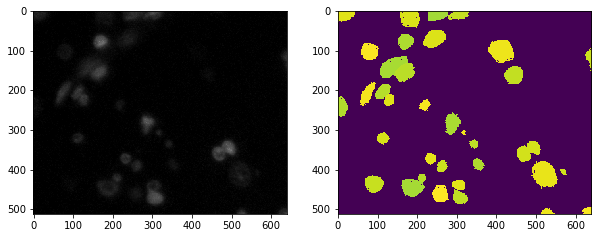

In [30]:
image, label = dataloader[ np.random.randint( len(dataloader) ) ]

plt.figure( figsize=(10,10)) 
plt.subplot(121)
plt.imshow( image )
plt.subplot(122)
plt.imshow( np.sum(label,axis=2)  )
plt.show()


3.3.0


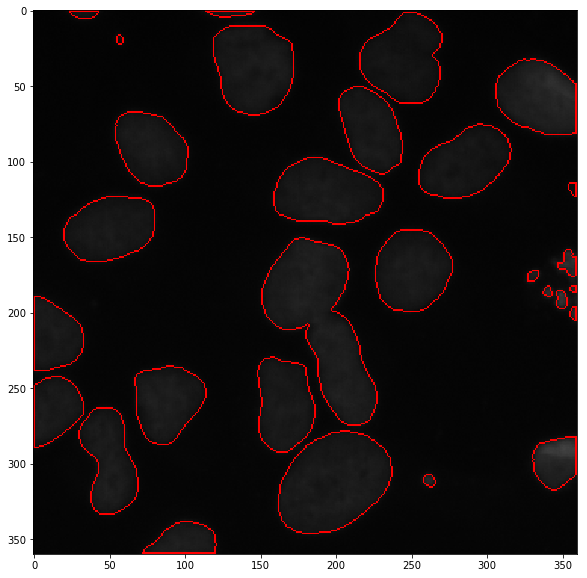

In [170]:

import cv2
print(cv2.__version__)

image, label = dataloader[ np.random.randint( len(dataloader) ) ] #np.random.randint( len(dataloader) )
label = np.sum(label,axis=2)

label = label.astype(np.uint8)
#label[label>0] = 255;
#_,label = cv2.threshold(label,127,255,0);
_,contours,_ = cv2.findContours(label, cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE )
for cnt in contours: cv2.drawContours(image, cnt, -1,  (255,0,0), 1)

plt.figure( figsize=(10,10))
plt.imshow(image)
plt.show()
        

514


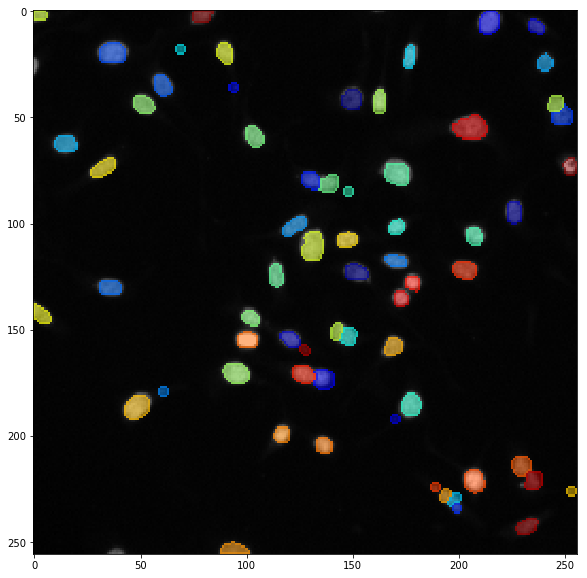

In [204]:
import cv2

def torgb(im):
    if len(im.shape)==2:
        im = np.expand_dims(im, axis=2) 
        im = np.concatenate( (im,im,im), axis=2 )
    return im
        
def setcolor(im, mask, color):
    
    tmp=im.copy()
    tmp=np.reshape( tmp, (-1, im.shape[2])  )   
    mask = np.reshape( mask, (-1,1))      
    tmp[ np.where(mask>0)[0] ,:] = color
    im=np.reshape( tmp, (im.shape)  )
    return im

def lincomb(im1,im2,mask, alpha):
    
    #im = np.zeros( (im1.shape[0], im1.shape[1], 3) )
    im = im1.copy()    
    
    row, col = np.where(mask>0)
    for i in range( len(row) ):
        r,c = row[i],col[i]
        #print(r,c)
        im[r,c,0] = im1[r,c,0]*(1-alpha) + im2[r,c,0]*(alpha)
        im[r,c,1] = im1[r,c,1]*(1-alpha) + im2[r,c,1]*(alpha)
        im[r,c,2] = im1[r,c,2]*(1-alpha) + im2[r,c,2]*(alpha)
    return im

def makebackgroundcell(labels):
    ch = labels.shape[2]
    cmap = plt.get_cmap('jet_r')
    imlabel = np.zeros( (labels.shape[0], labels.shape[1], 3) )    
    for i in range(ch):
        mask  = labels[:,:,i]
        color = cmap(float(i)/ch)
        imlabel = setcolor(imlabel,mask,color[:3])
    return imlabel

def makeedgecell(labels):
    ch = labels.shape[2]
    cmap = plt.get_cmap('jet_r')
    imedge = np.zeros( (labels.shape[0], labels.shape[1], 3) )    
    for i in range(ch):
        mask  = labels[:,:,i]
        color = cmap(float(i)/ch)
        mask = mask.astype(np.uint8)
        _,contours,_ = cv2.findContours(mask, cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE )
        for cnt in contours: cv2.drawContours(imedge, cnt, -1, color[:3], 1)
    return imedge

def makeimagecell(image, labels, alphaback=0.3, alphaedge=0.3):
    
    imagecell = image.copy()
    imagecell = imagecell - np.min(imagecell)
    imagecell = imagecell / np.max(imagecell)    
    imagecell = torgb(imagecell)
     
    mask  = np.sum(labels, axis=2)
    imagecellbackground = makebackgroundcell(labels)
    imagecelledge = makeedgecell(labels)
    maskedge = np.sum(imagecelledge, axis=2)
    
    imagecell = lincomb(imagecell,imagecellbackground, mask, alphaback )
    imagecell = lincomb(imagecell,imagecelledge, maskedge, alphaedge )
            
    return imagecell
    

k = np.random.randint( len(dataloader) )
print(k)

image, labels = dataloader[ 1 ]#256


plt.figure( figsize=(10,10))
imagecell = makeimagecell(image, labels, alphaback=0.5, alphaedge=0.5)
plt.imshow( imagecell )

#imlabel = makebackgroundcell(labels)
#plt.imshow( imlabel )

#imlabel = makeedgecell(labels)
#plt.imshow( imlabel )

plt.show()

    

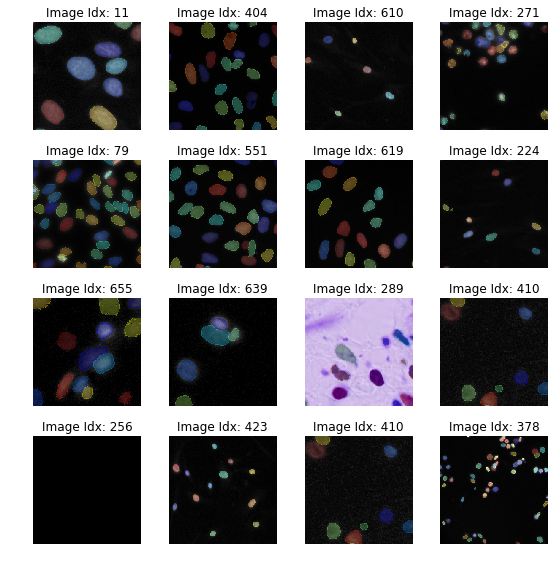

In [198]:
def display_samplas(dataloader, row=3,col=3, alphaback=0.3, alphaedge=0.2):
    """
    Display random data from dataset
    For debug only
    """
    fig, ax = plt.subplots(row, col, figsize=(8, 8), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})
    
    for i in range(row):
        for j in range(col):
            
            k = np.random.randint( len(dataloader) )
            image, labels = dataloader[ k ]
            imagecell = makeimagecell(image, labels, alphaback=alphaback, alphaedge=alphaedge)
            
            ax[i,j].imshow(imagecell)
            ax[i,j].set_title('Image Idx: %d' % (k,))

    for a in ax.ravel():
        a.set_axis_off()

    plt.tight_layout()
    plt.show()

    
display_samplas(dataloader,row=4, col=4)


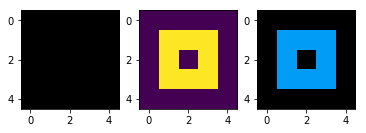

In [123]:
def torgb(im):
    if len(im.shape)==2:
        im = np.expand_dims(im, axis=2) 
        im = np.concatenate( (im,im,im), axis=2 )
    return im
        
def setcolor(im, mask, color):
    
    tmp=im.copy()
    tmp=np.reshape( tmp, (-1, im.shape[2])  )   
    mask = np.reshape( mask, (-1,1))  
    tmp[ np.where(mask>0)[0] ,:] = color
    im=np.reshape( tmp, (im.shape)  )
    return im



#test
im = np.zeros( (5,5) )
imrgb = torgb(im)
mask =[[0,0,0,0,0],
       [0,1,1,1,0],
       [0,1,0,1,0],
       [0,1,1,1,0],
       [0,0,0,0,0]
      ]
mask = np.array(mask)
imresult = setcolor(imrgb,mask,[255,100,10])
#print(imresult)

plt.subplot(131)
plt.imshow(imrgb)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(imresult)
plt.show()


    

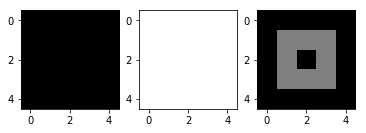

In [147]:
def lincomb(im1,im2,mask, alpha):
    im = np.zeros( (im1.shape[0], im1.shape[1], 3) )
    row, col = np.where(mask>0)
    for i in range( len(row) ):
        r,c = row[i],col[i]
        #print(r,c)
        im[r,c,0] = im1[r,c,0]*(1-alpha) + im2[r,c,0]*(alpha)
        im[r,c,1] = im1[r,c,1]*(1-alpha) + im2[r,c,1]*(alpha)
        im[r,c,2] = im1[r,c,2]*(1-alpha) + im2[r,c,2]*(alpha)
    return im
    
im1 = np.zeros( (5,5) )
imrgb1 = torgb(im1)
im2 = np.ones( (5,5) )
imrgb2 = torgb(im2)

mask =[[0,0,0,0,0],
       [0,1,1,1,0],
       [0,1,0,1,0],
       [0,1,1,1,0],
       [0,0,0,0,0]
      ]
mask = np.array(mask)
imresult = lincomb(imrgb1,imrgb2,mask, 0.5) 

plt.subplot(131)
plt.imshow(imrgb1)
plt.subplot(132)
plt.imshow(imrgb2)
plt.subplot(133)
plt.imshow(imresult)
plt.show()
